# Imports

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import copy
import os
import shutil

# Preprocess Data

In [26]:
# Set device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Define data transformations
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
}

# Load the dataset
data_dir = './data/flowers_labeled'
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split Dataset

In [27]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply respective transformations
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes

# Baseline Performance | Before Training

In [38]:
# Modify the ResNet18 model
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    # nn.Linear(num_ftrs, 512),
    # nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, len(class_names)),
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [39]:
# Evaluate the model on the test set
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Bluebell       0.09      0.50      0.15         4
   Buttercup       0.13      0.78      0.22         9
  Colts Foot       0.00      0.00      0.00        11
     Cowslip       0.00      0.00      0.00         9
      Crocus       0.00      0.00      0.00         4
    Daffodil       0.00      0.00      0.00         8
       Daisy       0.00      0.00      0.00        11
   Dandelion       0.00      0.00      0.00         8
  Fritillary       0.00      0.00      0.00         9
        Iris       0.00      0.00      0.00         7
 Lily Valley       0.00      0.00      0.00        12
       Pansy       0.00      0.00      0.00         7
    Snowdrop       0.00      0.00      0.00        10
   Sunflower       0.00      0.00      0.00         6
   Tigerlily       0.00      0.00      0.00         6
       Tulip       0.08      0.10      0.09        10
  Windflower       0.50      0.50      0.50         6

    accuracy              

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/ai-fast-demos-u959aKp3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set 

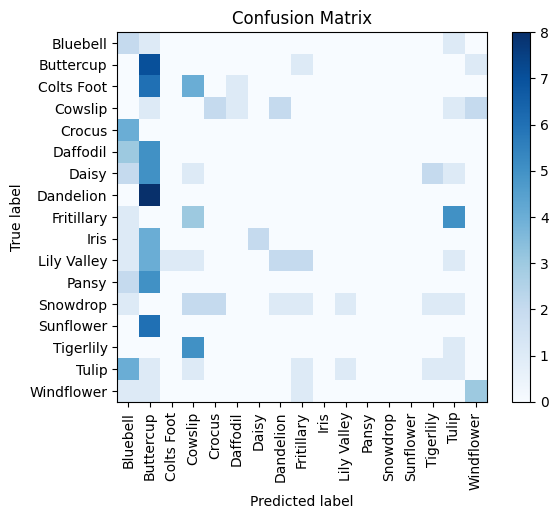

In [40]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Define Function to Train Model

In [41]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save the new best weights to a file with a timestamp
                torch.save(best_model_wts, f'../../saved_models/best_model_{epoch}_{best_acc:.4f}.pth')


    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

# Pass Hyper Parameters & Train Model

In [42]:
model_ft, train_loss, val_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 2.4452 Acc: 0.2829
val Loss: 1.7362 Acc: 0.6360
Epoch 1/14
----------
train Loss: 1.4031 Acc: 0.6972
val Loss: 1.0800 Acc: 0.8125
Epoch 2/14
----------
train Loss: 0.9138 Acc: 0.8339
val Loss: 0.7780 Acc: 0.8566
Epoch 3/14
----------
train Loss: 0.6535 Acc: 0.8917
val Loss: 0.6233 Acc: 0.8787
Epoch 4/14
----------
train Loss: 0.5395 Acc: 0.9106
val Loss: 0.5282 Acc: 0.9007
Epoch 5/14
----------
train Loss: 0.4280 Acc: 0.9338
val Loss: 0.4658 Acc: 0.8934
Epoch 6/14
----------
train Loss: 0.3712 Acc: 0.9453
val Loss: 0.4166 Acc: 0.9007
Epoch 7/14
----------
train Loss: 0.3345 Acc: 0.9495
val Loss: 0.4100 Acc: 0.9007
Epoch 8/14
----------
train Loss: 0.3243 Acc: 0.9548
val Loss: 0.4081 Acc: 0.8971
Epoch 9/14
----------
train Loss: 0.3307 Acc: 0.9527
val Loss: 0.4032 Acc: 0.8934
Epoch 10/14
----------
train Loss: 0.3069 Acc: 0.9590
val Loss: 0.3975 Acc: 0.9118
Epoch 11/14
----------
train Loss: 0.2903 Acc: 0.9611
val Loss: 0.3967 Acc: 0.9154
Epoch 12/14
--

# Plot Training and Validation Loss Curves

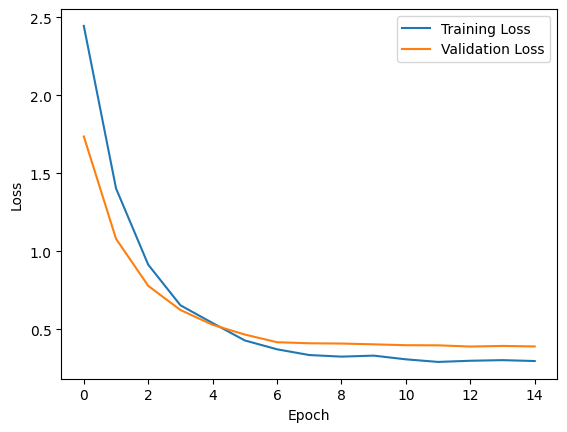

In [43]:
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
# Evaluate the model on the test set
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Bluebell       1.00      0.75      0.86         4
   Buttercup       1.00      0.89      0.94         9
  Colts Foot       0.85      1.00      0.92        11
     Cowslip       0.73      0.89      0.80         9
      Crocus       1.00      1.00      1.00         4
    Daffodil       0.78      0.88      0.82         8
       Daisy       1.00      0.91      0.95        11
   Dandelion       1.00      0.75      0.86         8
  Fritillary       1.00      0.89      0.94         9
        Iris       0.88      1.00      0.93         7
 Lily Valley       1.00      0.83      0.91        12
       Pansy       1.00      0.86      0.92         7
    Snowdrop       0.83      1.00      0.91        10
   Sunflower       0.86      1.00      0.92         6
   Tigerlily       1.00      1.00      1.00         6
       Tulip       0.90      0.90      0.90        10
  Windflower       0.83      0.83      0.83         6

    accuracy              

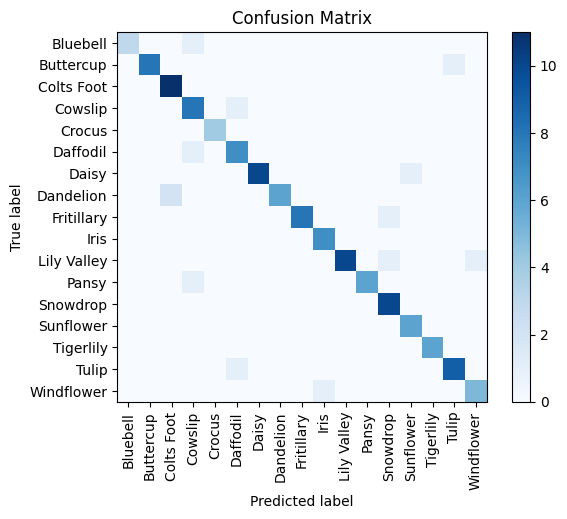

In [45]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()